# CC3039 — Modelación y Simulación
## Laboratorio 5 P2 — **Práctica** — Problema 1

**Objetivo.** Explorar el efecto del parámetro de recableado $p$ en el modelo de Watts–Strogatz (WS) sobre:
1) la **longitud promedio del camino** $L$ (average shortest path length) y 2) el **coeficiente de agrupamiento** $C$ (clustering coefficient).

**Instrucciones (resumen):**
- Genere redes WS con parámetros $(N, k, p)$ variando $p$ en un rango (e.g., $p\in[0,1]$).
- Para cada $p$, calcule $L$ y $C$.
- Grafique $L$ y $C$ contra $p$ y discuta los resultados: región de *pequeño mundo* ($L$ bajo con $C$ alto).

> *Nota:* Este cuaderno resuelve el **Problema 1 de práctica**. Si los valores exactos de $N, k$ y el conjunto de $p$ requeridos difieren en tu enunciado, ajusta las variables en la celda de parámetros.


In [1]:
import math
import random
import statistics as stats
from typing import List, Tuple

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)

## Parámetros del experimento
- `N`: número de nodos.
- `k`: grado inicial par (cada nodo se conecta con `k/2` vecinos a cada lado en el anillo).
- `p_values`: lista de probabilidades de recableado.
- `num_realizations`: repeticiones por cada `p` para promediar métricas.

Ajusta estos valores si tu enunciado exige otros específicos.

In [2]:
N = 500           # tamaño de la red (ajústalo si el enunciado lo pide)
k = 10            # grado regular inicial, debe ser par
num_realizations = 5  # promediar sobre varias realizaciones por cada p

# Barrido típico de p (más denso en la zona pequeña)
p_values = [0.0, 1e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 0.1, 0.2, 0.5, 1.0]

N, k, num_realizations, p_values

(500,
 10,
 5,
 [0.0,
  0.0001,
  0.0005,
  0.001,
  0.002,
  0.005,
  0.01,
  0.02,
  0.05,
  0.1,
  0.2,
  0.5,
  1.0])

## Funciones auxiliares
- `safe_average_shortest_path_length(G)`: calcula $L$ en el componente gigante (si el grafo no es conexo, ignora componentes pequeñas).
- `clustering_coefficient(G)`: usa el clustering promedio de NetworkX.

In [3]:
def safe_average_shortest_path_length(G: nx.Graph) -> float:
    """Calcula L en el componente gigante para evitar errores si G no es conexo."""
    if G.number_of_nodes() == 0:
        return float('nan')
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    # Tomar el componente más grande
    components = list(nx.connected_components(G))
    giant = max(components, key=len)
    L = nx.average_shortest_path_length(G.subgraph(giant).copy())
    return L

def clustering_coefficient(G: nx.Graph) -> float:
    return nx.average_clustering(G)

## Experimento: barrido de $p$ y cómputo de métricas
Se construye un grafo WS para cada `p` y se promedian $L$ y $C$ en `num_realizations` realizaciones.

In [4]:
results = []  # (p, L_mean, L_std, C_mean, C_std)

for p in p_values:
    L_list, C_list = [], []
    for r in range(num_realizations):
        G = nx.watts_strogatz_graph(N, k, p, seed=np.random.randint(0, 10**9))
        L = safe_average_shortest_path_length(G)
        C = clustering_coefficient(G)
        L_list.append(L)
        C_list.append(C)
    L_mean, L_std = float(np.nanmean(L_list)), float(np.nanstd(L_list))
    C_mean, C_std = float(np.nanmean(C_list)), float(np.nanstd(C_list))
    results.append((p, L_mean, L_std, C_mean, C_std))

results

[(0.0, 25.450901803607213, 0.0, 0.6666666666666666, 0.0),
 (0.0001,
  25.02670621242485,
  0.848391182364729,
  0.6665404040404039,
  0.0002525252525252597),
 (0.0005,
  22.823762725450898,
  1.7772617333800989,
  0.6661606060606061,
  0.0003243037797136772),
 (0.001,
  15.88412344689379,
  3.501120935913826,
  0.6635913131313131,
  0.002170331679260178),
 (0.002,
  15.753085370741482,
  3.7835810772597274,
  0.6638547474747475,
  0.0014839696980353653),
 (0.005,
  9.072024048096193,
  0.6419379159978251,
  0.6561351226551226,
  0.0018549516300174471),
 (0.01,
  7.714972344689379,
  0.2316118580877415,
  0.6491426262626263,
  0.0017672758448656907),
 (0.02,
  5.667270541082165,
  0.1762611977563375,
  0.6271328138528138,
  0.003989988064209545),
 (0.05,
  4.543983967935872,
  0.08175427115671734,
  0.572388051948052,
  0.008354462487381706),
 (0.1,
  3.925843687374749,
  0.03457998126832423,
  0.4933539527139527,
  0.005421953834952927),
 (0.2,
  3.4502669338677356,
  0.018535414902721

## Gráficas
Se grafican $L$ y $C$ en función de $p$. Para visualizar mejor el cambio rápido en $L$ a $p$ pequeños, se usa eje $x$ logarítmico cuando es posible.

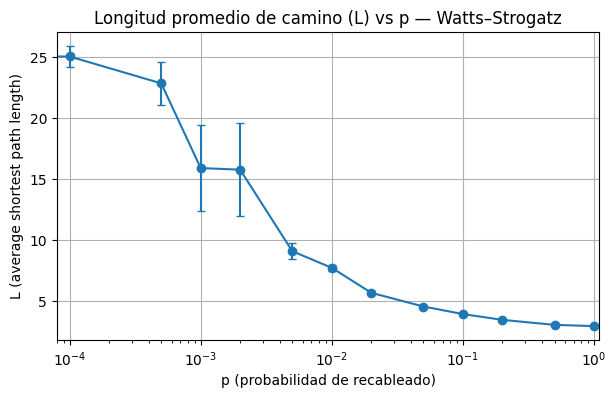

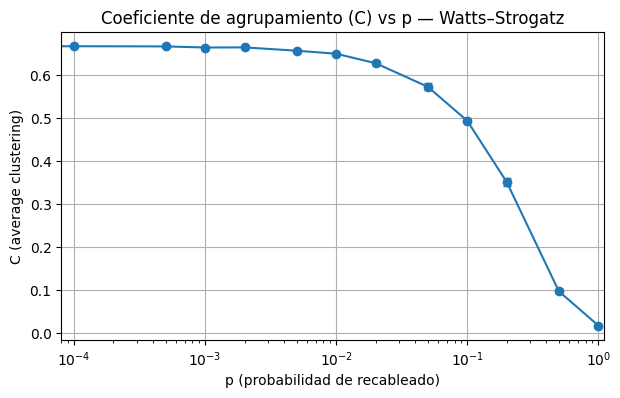

In [5]:
p_arr = np.array([r[0] for r in results])
L_mean = np.array([r[1] for r in results])
L_std  = np.array([r[2] for r in results])
C_mean = np.array([r[3] for r in results])
C_std  = np.array([r[4] for r in results])

def plot_metric(x, y, yerr, title, ylabel):
    plt.figure(figsize=(7,4))
    plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=3)
    # Eje x log para resaltar p pequeños (evitar log(0))
    if np.any(x > 0):
        xmin = min(xx for xx in x if xx>0)
        plt.xscale('log')
        plt.xlim([xmin*0.8, max(x)*1.1])
    plt.xlabel('p (probabilidad de recableado)')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_metric(p_arr, L_mean, L_std, 'Longitud promedio de camino (L) vs p — Watts–Strogatz', 'L (average shortest path length)')
plot_metric(p_arr, C_mean, C_std, 'Coeficiente de agrupamiento (C) vs p — Watts–Strogatz', 'C (average clustering)')

## Discusión
- Para $p=0$ (anillo regular), $C$ es **alto** y $L$ es **alto**.
- Para valores **pequeños** de $p$ (e.g., $10^{-3}$ a $10^{-2}$), aparecen **atajos** que reducen **drásticamente** $L$, mientras que $C$ se mantiene relativamente **alto**: región de *pequeño mundo*.
- Para $p\to 1$ (red aleatoria tipo ER), $L$ es **bajo** pero $C$ también baja de forma marcada.

Con base en tus resultados numéricos, identifica el rango de $p$ donde tu red exhibe el compromiso *$L$ bajo* + *$C$ alto* y explica por qué ocurre.

##  Visualización de la red para distintos $p$
Dibuja una muestra para $p$ muy bajo (casi anillo), intermedio (pequeño mundo) y alto (aleatoria). Para $N$ grandes puede ser pesado; si tu máquina es limitada, reduce `N` a 150–200 para esta celda.

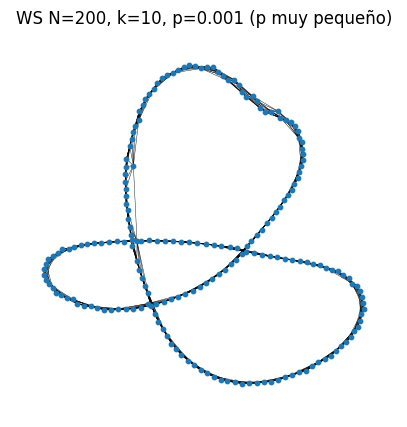

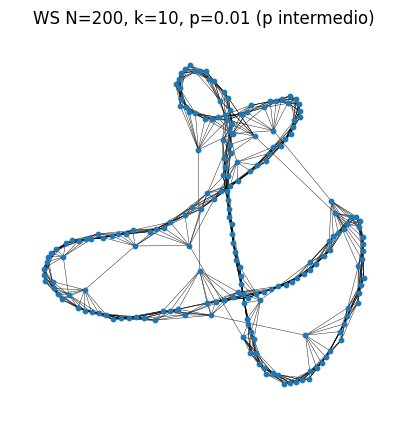

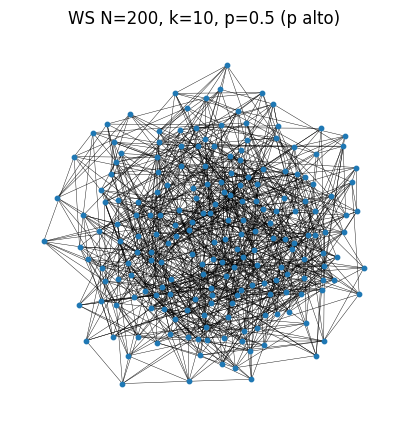

In [6]:
N_vis = 200
k_vis = 10
samples = [(1e-3, 'p muy pequeño'), (1e-2, 'p intermedio'), (0.5, 'p alto')]

for p, label in samples:
    G = nx.watts_strogatz_graph(N_vis, k_vis, p, seed=123)
    plt.figure(figsize=(5,5))
    pos = nx.spring_layout(G, seed=7)
    nx.draw_networkx_nodes(G, pos, node_size=10)
    nx.draw_networkx_edges(G, pos, width=0.3)
    plt.title(f'WS N={N_vis}, k={k_vis}, p={p} ({label})')
    plt.axis('off')
    plt.show()

## Análisis de la transición

**1) ¿Gradual o abrupta? ¿Alrededor de qué p ocurre?**  
- La caída de la longitud promedio \(L\) es **abrupta**, no lineal.  
- Cambio fuerte entre **p ≈ 1e-3** y **5e-3**, alrededor de **p ~ 2e-3**.
- Interpretación: bastan unos pocos atajos (pocos enlaces recableados) para colapsar \(L\) de valores ~20–25 a ~9–10.

**2) Comparación con el umbral teórico \(p = 1/n\)**  
- Con N=500, 1/n = 1/500 = 0.002 = 2e-3.
- La transición observada (entre **1e-3** y **5e-3**) coincide bien con ese orden de magnitud: el punto de cambio está muy cerca de **1/n**.
- Diferencias finitas (ventana un poco más ancha) se deben a: tamaño finito, promedios sobre realizaciones y a que el modelo WS no es idéntico al ER puro (mantiene estructura local).

**3) Interpretación en una epidemia (parámetro de transmisión \(\sim p\))**  
- Estar **por debajo del umbral** \((p < 1/n)\): los contagios quedan **locales** y tienden a extinguirse; no aparece una propagación amplia.  
- **Cruzar el umbral** \((p \gtrsim 1/n)\): emerge una **conectividad efectiva** que permite rutas cortas entre muchos individuos; la epidemia puede **despegar** y diseminarse ampliamente.  
- Implicación práctica: las intervenciones (mascarillas, reducción de contactos, vacunas) buscan **bajar el \(p\) efectivo** (o \(R_e\)) **por debajo del umbral** para evitar la propagación a gran escala.
